## 이미지 업로드 and 블러, 노이즈 처리

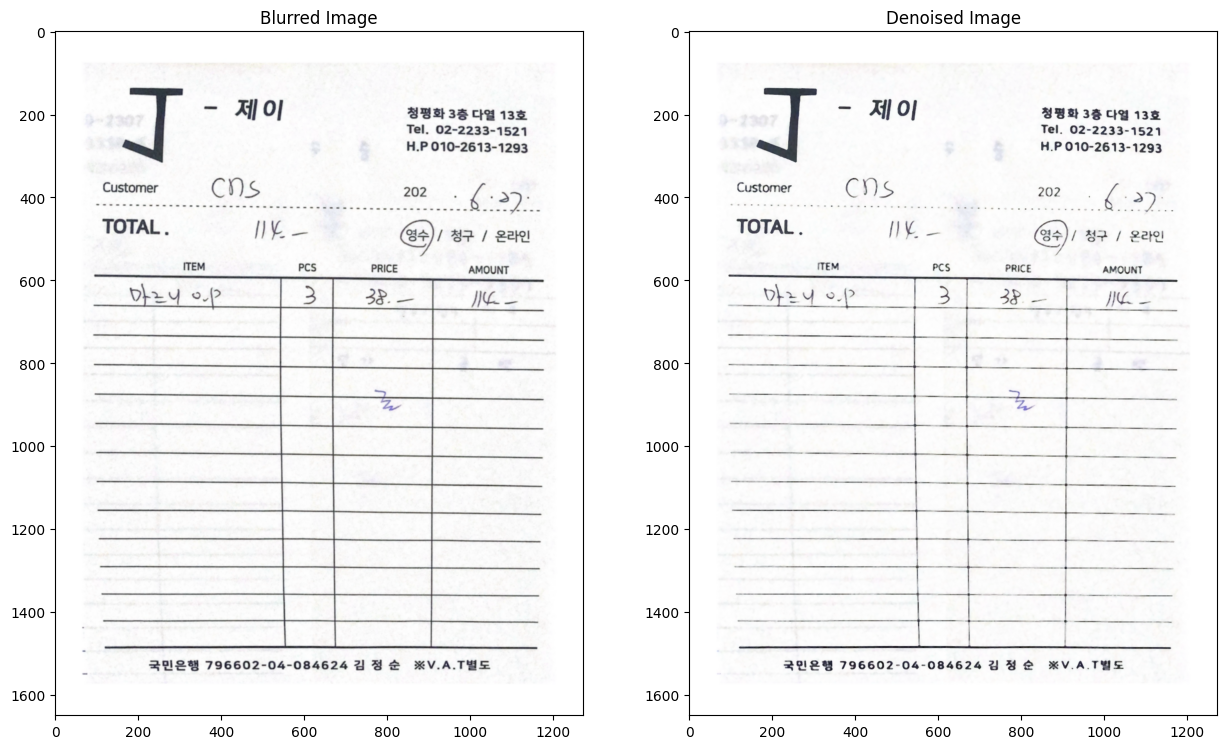

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지를 로드합니다.
image = cv2.imread('/Users/402-07/YoungMan_projectDE/receipt_list/h12.jpg')

# 가우시안 블러(Gaussian Blur)를 사용하여 노이즈를 줄입니다.
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# 중간값 필터(Median Filter)를 사용하여 소금-후추 노이즈를 제거합니다.
denoised_image = cv2.medianBlur(image, 5)

# 결과를 저장하거나 보여줍니다.
cv2.imshow('Denoised Image', denoised_image)

# 이미지를 나란히 표시하기 위한 subplot 설정
plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)  # 첫 번째 subplot
plt.imshow(blurred_image)
plt.title('Blurred Image')

plt.subplot(1, 2, 2)  # 두 번째 subplot
plt.imshow(denoised_image)
plt.title('Denoised Image')

plt.show()


## 영수증 텍스트 박스 검출

C:\Users\402-07\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


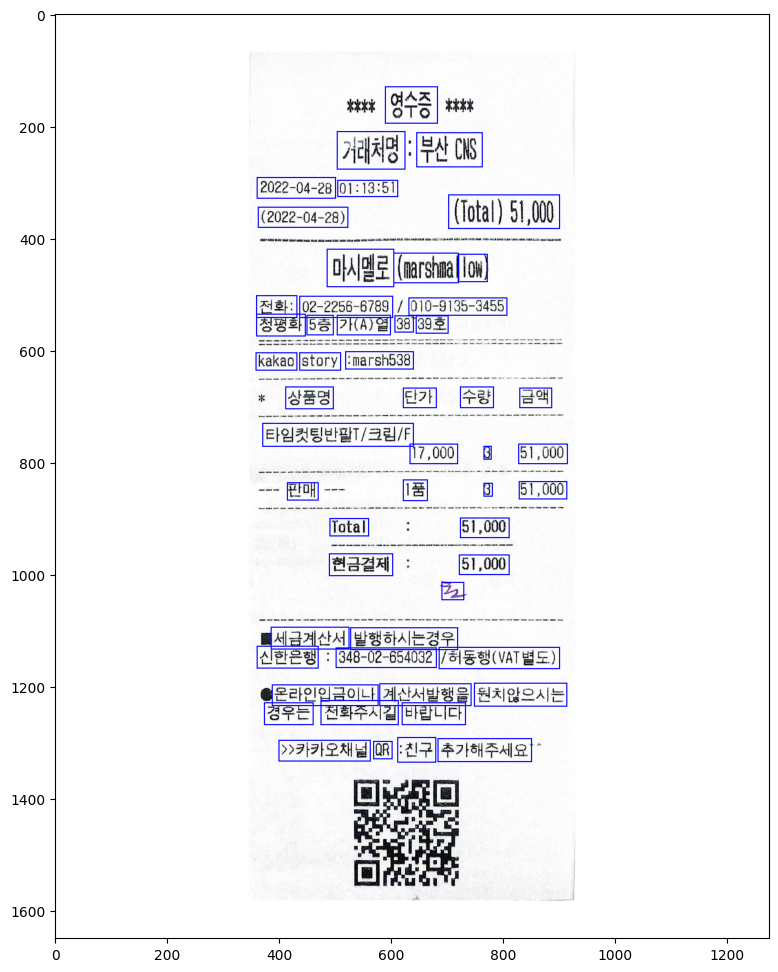

In [1]:
import cv2
import easyocr
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

num = "01"
reader = easyocr.Reader(['ko', 'en'])
result =  reader.readtext(f'/Users/402-07/YoungMan_projectDE/receipt_list/{num}.jpg', width_ths = 0.1)

img = cv2.imread(f'/Users/402-07/YoungMan_projectDE/receipt_list/{num}.jpg')

img = Image.fromarray(img)
font = ImageFont.truetype("malgun.ttf", 40)
draw = ImageDraw.Draw(img)

for i in result:
  x = i[0][0][0]
  y = i[0][0][1]
  w = i[0][1][0] - i[0][0][0]
  h = i[0][2][1] - i[0][1][1]

# 나쁘지 않은 영수증 : h04, h10, h12
  draw.rectangle(((x, y), (x+w, y+h)), outline="blue", width=2)
  # draw.text((int((x+x+w)/2), y-40), str(i[1]), font=font, fill="blue")

plt.figure(figsize=(15, 12))
plt.imshow(img)
plt.show()

## 정확도 검사

In [2]:
import easyocr

reader = easyocr.Reader(['en', 'ko'])

results = reader.readtext('/Users/402-07/YoungMan_projectDE/receipt_list/01.jpg')

num = 0
count = 0
for (bbox, text, prob) in results:
    print(f"{text} // prob: {prob:.4f}")
    num += prob
    count += 1
print()
print(f"average probability : {num / count}")

영수증 // prob: 0.9419
거대처명 // prob: 0.5406
부산 [I // prob: 0.2864
2022-04-28 01:13:51 // prob: 0.5415
(2022-04-28) // prob: 0.9030
(Tatal) 5l,@0 // prob: 0.0761
마시델로 (marahmallo) // prob: 0.4673
전화: 02-2256-6789 // prob: 0.6654
010-9135-5455 // prob: 0.6042
청평화 5총  가(A)열 38 39호 // prob: 0.4371
kakao story ;marsh538 // prob: 0.8577
상품명 // prob: 0.9824
단가 // prob: 0.9998
수량 // prob: 0.9999
금액 // prob: 0.9999
타임컷팅반팔T / 크림/F // prob: 0.3427
17,000 // prob: 0.9969
3 // prob: 0.3923
51,000 // prob: 0.9757
판매 // prob: 0.9996
l품 // prob: 0.2599
3 // prob: 0.9991
51,000 // prob: 0.8751
Tatal // prob: 0.9969
51,000 // prob: 0.9357
현금결제 // prob: 0.9950
51,000 // prob: 0.9064
고 // prob: 0.2624
(세금계산서 발행하시는경우 // prob: 0.5863
신한은행 // prob: 0.9714
348-02-654032  /허동행(VAT별도) // prob: 0.6771
온라인입금이다   계산서발행울 원치않으시논 // prob: 0.4557
경우는 // prob: 0.5774
전화주시길 바갑니다 // prob: 0.4875
>>카카오채널 OR :친구 추가해주세요 // prob: 0.4986

average probability : 0.6998561975993459


## 예외처리 및 데이터 컬럼 추출

In [31]:
import easyocr


update_text = []
json_text = [] 

def extract_text_from_image(image_path, languages=['en', 'ko']):
    global update_text

    # OCR 리더 초기화
    

    # blocked_characters = 'COUBJu니<{}>|]\:[_+=`!@~#$%^&*)(?;\"\''
    # 이미지 파일에서 텍스트 추출
    # 황금비율  width_ths = 15, ycenter_ths = 0.5
    try:
        text_lists = []
        reader = easyocr.Reader(languages)
        result = reader.readtext(image_path, width_ths = 15, ycenter_ths = 0.5, blocklist=blocked_characters)
    
        flag = False
        list = []
    
        # 추출된 텍스트 출력
        for detection in result:
            print(detection[1])
    
        for (bbox, text, prob) in result:
                list.append(text)
        
        for text in list:
            if flag and ("판매소계" in text or "판매" in text or "판매량" in text or "만" in text or "판" in text or "민" in text or "소계" in text):
                break
            if flag:
                text_lists.append(text)
            if "금액" in text or "수량" in text or "단가" in text:
                flag = True
            
    
        # 텍스트를 추출할 때,  width_ths = 15, ycenter_ths = 0.5 의 비율로 박스를 조정하면 [품명, 단가 수량 금액] 별로 나온다.
        # 품명은 문제 없지만, 단가 수량 금액을 따로 딕셔너리로 바꾸려면 공백을 기준으로 split을 해야함.
        # 그래서 다음 코드는 짝수번째에 해당하는 배열은 그대로 두고 홀수번째에 해당하는 배열을 조정하는 것이다.
        dt = {}
        flag2 = False

    
        if("," in text_lists[0] or "." in text_lists[0]) :
            flag2 = True
    
        for i in range(0, len(text_lists)):
            if(flag2) :
                result_text = text_lists[i].split()
                if(len(result_text) == 4) :
                    dt['품목'] = result_text[0]
                    dt['단가'] = result_text[1].replace("I", "1")
                    dt['수량'] = result_text[2]
                    dt['금액'] = result_text[3] 
                    json_text.append(dt)
                    dt = {}
                else :
                    k = 0
                    n = 0
                    q = 0
                    for (j,c) in enumerate(text_lists[i]) :
                        if(c == " " and text_lists[i][j+1] == " ") :
                            dt['품목'] = text_lists[i][0:j]
                            k = j
                            break
                    text2 = text_lists[i][k+1:].strip()
                    for (m,c) in enumerate(text2) :
                         if(c == " ") :
                             dt['단가'] = text2[0:m]
                             n = m
                             break
                    text3 = text2[n+1:].strip()
                    for (z,c) in enumerate(text3) :
                        if(c == " ") :
                            dt["수량"] = text3[0:z]
                            q = z
                            break
                            
                    text4 = text3[q+1:].strip()
                    for (y,c) in enumerate(text4) :
                        if(c == " ") :
                            text4 = text4[0:y] + "." + text4[y+1:]
    
                    dt["금액"] = text4
                    
                    json_text.append(dt)
                    dt={}
            else:
                if i % 2 == 1:
                    result_text = text_lists[i].split()
                    result_text = [item for item in result_text if item]
                    update_text.append(result_text)
                    dt['단가'] = result_text[0]
                    dt['수량'] = result_text[1]
                    if len(result_text) == 3 :
                        dt['금액'] = result_text[2]
                    json_text.append(dt)
                    dt = {}
                else:
                    update_text.append(text_lists[i])
                    dt['품목'] = text_lists[i] 
    except:
        text_lists = []
        reader = easyocr.Reader(['en', 'ko'])
        # result = reader.readtext(image_path, width_ths = 15, ycenter_ths = 0.5, blocklist=blocked_characters)
        result = reader.readtext('/Users/402-07/YoungMan_projectDE/receipt_list/12.jpg')

        flag = False
        list = []
    
        # 추출된 텍스트 출력
        for detection in result:
            print(detection[1])
    
        for (bbox, text, prob) in result:
                list.append(text)
        
        for text in list:
            if flag and ("국민은행" in text or "판매소계" in text or "판매" in text or "판매량" in text or "만" in text or "판" in text or "민" in text or "소계" in text):
                break
            if flag:
                text_lists.append(text)
            if "AMOUNT" in text or "금액" in text or "수량" in text or "단가" in text:
                flag = True
            
        print("$$$$$$$$", text_lists)
        # 텍스트를 추출할 때,  width_ths = 15, ycenter_ths = 0.5 의 비율로 박스를 조정하면 [품명, 단가 수량 금액] 별로 나온다.
        # 품명은 문제 없지만, 단가 수량 금액을 따로 딕셔너리로 바꾸려면 공백을 기준으로 split을 해야함.
        # 그래서 다음 코드는 짝수번째에 해당하는 배열은 그대로 두고 홀수번째에 해당하는 배열을 조정하는 것이다.
        dt = {}
    
        dt['품목'] = text_lists[0]
        dt['수량'] = text_lists[1].replace("I", "1")
        dt['단가'] = text_lists[2].replace("-", "000")
        dt['금액'] = text_lists[3].replace("I", "1").replace("C", "4") + "000"
        json_text.append(dt)
        dt = {}
        
       


# 아쉬운 리스트 : 05(짝수번째 배열을 통째로 인식함), 06(짝수번째 배열을 통째로 인식함), 08(짝수번째 배열을 통째로 인식함) 10(컬럼이 표시 안됨), 12(인식을 못함),
# 13(인식을 못함), 14(인식을 못함), 16(인식을 못함), 18(인식을 못함)
# 수정 성공 : 06(블록리스트를 이용하여 수정함)

# 되는거 : 01, 02, 03, 04, 05, 06, 07, 08, 09, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26
# 깔끔하진 않지만 컬럼에 들어오는거 : 06, 10, 12, 19
# 안되는거 : 
# 이미지 파일 경로 설정
image_path = '/Users/402-07/YoungMan_projectDE/receipt_list/12.jpg'  # 본인이 사용하는 이미지 파일로 경로를 변경하세요.

# 언어 설정 및 이미지에서 텍스트 추출
extract_text_from_image(image_path, languages=['en', 'ko'])
# print(text_lists)
# print(update_text)
print(json_text)


부산)cns
게이
새밀행
2022
04
14(목) (10:34:36
PLANNER(플래너)
lI 그노
5층
5/1호
IEL: 010-8945-35f;5
KAKAO IA K: planrer20l8
KAKAO 9IOF;Y planrer1g20
INSTAGIAM: plarier5l1
22-04-14('}
120,000
임수
품명
난기 수량
베리고세티보리/
15,000
2
'30,UUU)
베리 군세티/연두-
5,000
90,OUU
만 매소계
2건
8
120,000
전
잔:
당일합계:
7
120,000
현금금액:
120,000
당
잔:
0
매입전잔:
매입산액:
0
_ _ - - = _- -
입금처: 우리은행 1005-8C3
509751 (끌래니)
자료는 매월 5일 마감이벼 세액 선입금
확인후 발행뵙니다. (VA T별도)
24500486703033
$$$$$$$$ ['베리고세티보리/', '15,000', '2', "'30,UUU)", '베리 군세티/연두-', '5,000', '90,OUU']
[{'품목': '베리고세티보리/', '수량': '15,000', '단가': '2', '금액': "'30,UUU)000"}]


## 정규식을 이용한 날짜 추출 

In [11]:
import easyocr
import re

text_list = []
def find_by_date(image_path, languages=['en', 'ko']):
    global text_list

    # OCR 리더 초기화
    reader = easyocr.Reader(languages)

    blocked_characters = ';이터,'
    
    # 이미지 파일에서 텍스트 추출
    result = reader.readtext(image_path, width_ths = 0.5, ycenter_ths = 0.5, blocklist=blocked_characters)

    # 추출된 텍스트 확인 
    # for detection in result:
    #     print(detection[1])

    for (bbox, text, prob) in result:
        text_list.append(text)

    # 정규식 패턴
    pattern = r'(\d{4}-\d{2}-\d{2})'

    for text in text_list:
        match = re.search(pattern, text)
        month_match = re.search(date_pattern, text)

        if match:
            date_part = match.group(1)  # 날짜 부분
            print(date_part)
            break
        # elif month_match:
        #     month_part = month_match.group(1)
        #     print(month_part)
        #     break

# 사용 가능 01, 02, 03, 04, 05, 07, 08, 09, 11, 15, 17

image_path = '/Users/402-07/YoungMan_projectDE/receipt_list/04.jpg'
print(text_list)
find_by_date(image_path, languages=['en', 'ko'])

[]
2022-04-25


## 추출한 텍스트를 json 형식으로 변환

In [32]:
import json

json_text = json.dumps(json_text, ensure_ascii=False, indent=4)


print(json_text)


[
    {
        "품목": "베리고세티보리/",
        "수량": "15,000",
        "단가": "2",
        "금액": "'30,UUU)000"
    }
]
